In [4]:
!pip install pydub

In [5]:
import os
from pydub import AudioSegment
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # Verilerin ve sınıfların yolları
# data_dir = '/content/drive/MyDrive/SongsTest'
# output_dir = '/content/drive/MyDrive/SongTestSegments'
# classes = ['CountryTest', 'EDMTest', 'Hip Hop-RapTest', 'PopTest', 'R&BTest', 'RockTest']

# # Çıktı dizinini oluşturma
# os.makedirs(output_dir, exist_ok=True)

In [6]:
data_dir = '/content/drive/MyDrive/yazlab/divide'

In [7]:
classes = ['azerice', 'kazakca', 'kirgizca', 'ozbekce', 'turkce']

In [ ]:
# # Drive klasör erişim kontrolleri için - Bu kısım Drive'daki dosyaların önbelleğe alınıp kolay erişilebilmesi için gereklidir.
# for class_name in classes:
#     class_output_dir = os.path.join(output_dir, class_name)
#     try:
#         file_list = os.listdir(class_output_dir)
#         print(f"Directory '{class_output_dir}' contains {len(file_list)} files.")
#     except OSError as e:
#         print(f"Error accessing directory {class_output_dir}: {e}")

In [ ]:
# # Her bir sınıf için ses dosyalarını işleme
# for label, class_name in enumerate(classes):
#     class_dir = os.path.join(data_dir, class_name)
#     class_output_dir = os.path.join(output_dir, class_name)
#     os.makedirs(class_output_dir, exist_ok=True)

#     for filename in os.listdir(class_dir):
#         if filename.endswith('.mp3 adlı dosyanın kopyası'):
#             file_path = os.path.join(class_dir, filename)
#             audio = AudioSegment.from_file(file_path, format='mp3')

#             # 10 saniyelik segmentlere ayırma
#             duration = 10 * 1000  # 10 saniye milisaniye cinsinden
#             for i in range(0, len(audio), duration):
#                 segment = audio[i:i + duration]
#                 if len(segment) < duration:
#                     segment = segment + AudioSegment.silent(duration - len(segment))  # 10 saniyeye tamamla
#                 segment_filename = f'{os.path.splitext(filename)[0]}_{i // duration}.mp3'
#                 segment_path = os.path.join(class_output_dir, segment_filename)
#                 segment.export(segment_path, format='mp3')

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
from pydub import AudioSegment
import io
import librosa

In [9]:
import numpy as np
from tqdm import tqdm

# Segmentleri ve etiketleri yüklemek için listeler
segments = []
labels = []

for label, class_name in enumerate(classes):
    class_data_dir = os.path.join(data_dir, class_name)

    # İlerleme göstergesi için tqdm kullanımı
    files = [f for f in os.listdir(class_data_dir) if f.endswith('.wav')]
    for filename in tqdm(files, desc=f"Loading {class_name} segments"):
        file_path = os.path.join(class_data_dir, filename)

        try:
            # `librosa` ile ses dosyasını yükleyin
            audio, sr = librosa.load(file_path, sr=16000)
            segment_array = np.array(audio)

            # Check if the segment array has the same shape as the others
            if segments and segment_array.shape != segments[0].shape:
                # Normalize and fix the length of the segment array
                segment_array = librosa.util.normalize(segment_array)
                segment_array = librosa.util.fix_length(segment_array, size=segments[0].shape[0])

            segments.append(segment_array)
            labels.append(label)

        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

# Sonuçları kontrol etme
print(f"Loaded {len(segments)} segments with corresponding labels.")

Loading turkce segments: 100%|██████████| 3850/3850 [04:53<00:00, 13.13it/s]

Loaded 19678 segments with corresponding labels.


In [10]:
# Segmentleri ve etiketleri numpy dizilerine dönüştürme
segments_np = np.array(segments)
labels_np = np.array(labels)

In [11]:
# Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(segments_np, labels_np, test_size=0.2, random_state=42)

In [12]:
print(f'Toplam dosya sayısı: {len(segments_np)}')
print(f'Eğitim seti dosya sayısı: {len(X_train)}')
print(f'Test seti dosya sayısı: {len(X_test)}')

Toplam dosya sayısı: 19678
Eğitim seti dosya sayısı: 15742
Test seti dosya sayısı: 3936


In [13]:
from transformers import AutoFeatureExtractor, UniSpeechSatForSequenceClassification
import torch
from torch.utils.data import DataLoader, TensorDataset

In [14]:
# ASTFeatureExtractor'ı başlatma
feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/unispeech-sat-base-100h-libri-ft")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

In [15]:
# Ses verilerini özelliklere dönüştürme
X_train_features = feature_extractor(X_train, sampling_rate=16000, return_tensors="pt")
X_test_features = feature_extractor(X_test, sampling_rate=16000, return_tensors="pt")

In [16]:
# Numpy verilerini PyTorch tensörlerine dönüştürme ve DataLoader oluşturma
train_dataset = TensorDataset(X_train_features['input_values'], torch.tensor(y_train))
test_dataset = TensorDataset(X_test_features['input_values'], torch.tensor(y_test))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [17]:
# ASTForAudioClassification modelini başlatma
model = UniSpeechSatForSequenceClassification.from_pretrained("microsoft/unispeech-sat-base-100h-libri-ft", num_labels=len(classes), ignore_mismatched_sizes=True)

config.json:   0%|          | 0.00/1.55k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of UniSpeechSatForSequenceClassification were not initialized from the model checkpoint at microsoft/unispeech-sat-base-100h-libri-ft and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# Optimizasyon fonksiyonunu tanımlama
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Kayıp fonksiyonu tanımlama
loss_fn = torch.nn.CrossEntropyLoss()

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

UniSpeechSatForSequenceClassification(
  (unispeech_sat): UniSpeechSatModel(
    (feature_extractor): UniSpeechSatFeatureEncoder(
      (conv_layers): ModuleList(
        (0): UniSpeechSatGroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x UniSpeechSatNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x UniSpeechSatNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): UniSpeechSatFeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout

In [21]:
def train_epoch(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    correct_predictions = 0

    for batch in train_loader:
        input_values, labels = batch
        input_values = input_values.to(device)
        labels = labels.to(device)

        outputs = model(input_values.to(device))
        logits = outputs.logits.to(device)
        loss = loss_fn(logits, labels)

        total_loss += loss.item()
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return total_loss / len(train_loader), correct_predictions.double() / len(train_loader.dataset)

In [22]:
all_preds = []
all_labels = []

def eval_model(model, test_loader, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for batch in test_loader:
            input_values, labels = batch
            input_values = input_values.to(device)
            labels = labels.to(device)

            outputs = model(input_values.to(device))
            logits = outputs.logits.to(device)
            loss = loss_fn(logits, labels)

            total_loss += loss.item()
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(test_loader), correct_predictions.double() / len(test_loader.dataset), all_preds, all_labels

In [23]:
num_epochs = 20
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [24]:
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')

    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
    test_loss, test_acc, test_preds, test_labels = eval_model(model, test_loader, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f'Train Loss: {train_loss}, Train Accuracy: {train_acc}')
    print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')

Epoch 1/20
Train Loss: 1.6161419878887937, Train Accuracy: 0.19851353068225128
Test Loss: 1.6093536591142175, Test Accuracy: 0.20579268292682928
Epoch 2/20
Train Loss: 1.6110600594098006, Train Accuracy: 0.19870410367170624
Test Loss: 1.613585089764944, Test Accuracy: 0.1976626016260163
Epoch 3/20
Train Loss: 1.615787759423256, Train Accuracy: 0.20067335789607418
Test Loss: 1.612560503366517, Test Accuracy: 0.1948678861788618
Epoch 4/20
Train Loss: 1.6130624326263987, Train Accuracy: 0.20016516325752762
Test Loss: 1.6095586113813447, Test Accuracy: 0.1976626016260163
Epoch 5/20
Train Loss: 1.6099211688691037, Train Accuracy: 0.19933934696988945
Test Loss: 1.6099367854071827, Test Accuracy: 0.20579268292682928
Epoch 6/20
Train Loss: 1.610765338913212, Train Accuracy: 0.20143564985389403
Test Loss: 1.609983966117952, Test Accuracy: 0.1986788617886179
Epoch 7/20
Train Loss: 1.6125627289700315, Train Accuracy: 0.204802439334265
Test Loss: 1.6094881586912202, Test Accuracy: 0.19867886178861

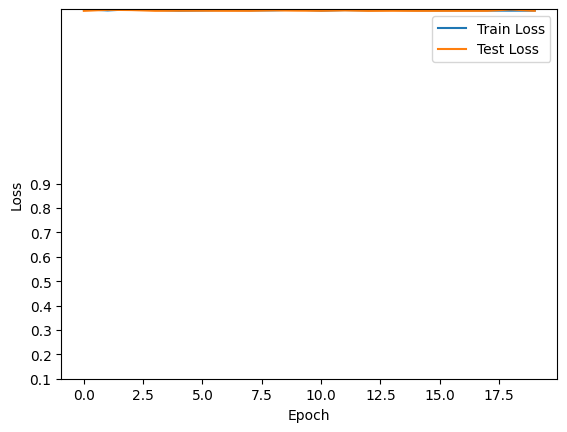

In [25]:
# Accuracy ve loss grafikleri
plt.figure()
plt.subplot(1, 1, 1)
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yticks([i/10 for i in range(1, 10)])
plt.legend()

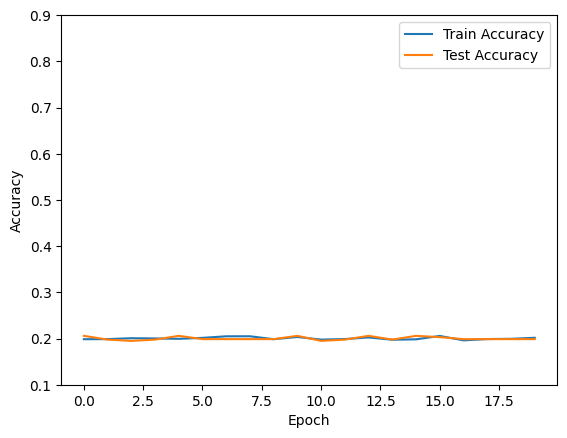

In [26]:
# plt.subplot(1, 2, 2)
# plt.plot(range(num_epochs), train_accuracies, label='Train Accuracy')
# plt.plot(range(num_epochs), test_accuracies, label='Test Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# Train accuracy verilerini CPU belleğine kopyala
train_accuracies_cpu = [acc.cpu().numpy() for acc in train_accuracies]
test_accuracies_cpu = [acc.cpu().numpy() for acc in test_accuracies]

# Grafik çizdirme işlemi
plt.figure()
plt.subplot(1, 1, 1)
plt.plot(range(num_epochs), train_accuracies_cpu, label='Train Accuracy')
plt.plot(range(num_epochs), test_accuracies_cpu, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.yticks([i/10 for i in range(1, 10)])
plt.legend()

In [27]:
plt.show()

In [28]:
# Precision, Recall, F1-Score hesaplama
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='macro')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

Precision: 0.19999999999999998
Recall: 0.20000000000000004
F1-Score: 0.1804953358358857


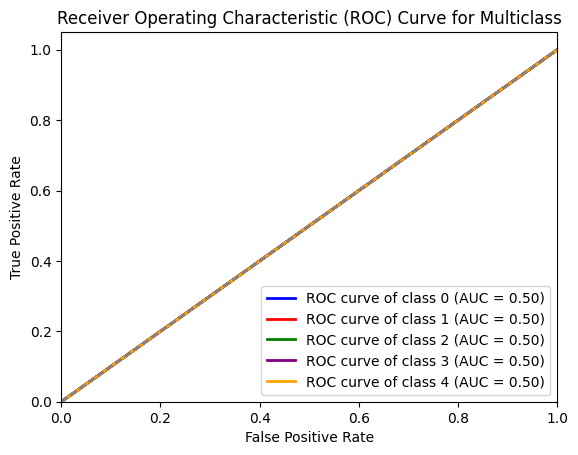

In [29]:
from sklearn.metrics import auc, roc_curve, roc_auc_score, confusion_matrix
import seaborn as sns
from sklearn.preprocessing import label_binarize

labels = np.array(all_labels)
preds = np.array(all_preds)

# Sınıfları ikili hale getirin
n_classes = len(np.unique(labels))
labels = label_binarize(labels, classes=[0, 1, 2, 3, 4])
preds = label_binarize(preds, classes=[0, 1, 2, 3, 4])

# Her sınıf için ROC ve AUC hesapla
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labels[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC eğrisini çizdir
plt.figure()
colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass')
plt.legend(loc="lower right")
plt.show()

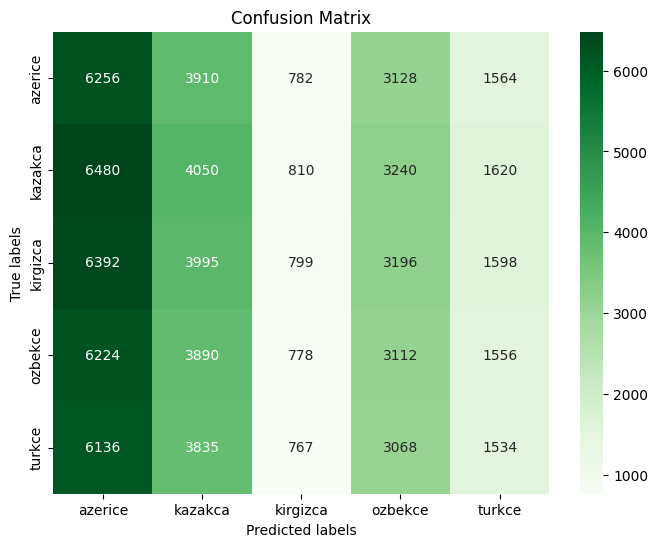

In [30]:
# Confusion matrix oluştur
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [31]:
from sklearn.metrics import classification_report
import pandas as pd

# Sınıfları ikili hale getirin
class_names = ['darija', 'iraqi', 'egyptian', 'gulf', 'levantine']

# Classification report oluştur
report = classification_report(labels, preds, target_names=class_names, output_dict=True)

# DataFrame'e dönüştür ve precision ve recall sütunlarını seç
df_report = pd.DataFrame(report).transpose()
df_precision_recall = df_report[['precision', 'recall']]

# Precision ve recall değerlerini tablo olarak yazdır
print(df_precision_recall)

              precision    recall
darija         0.198679  0.400000
iraqi          0.205793  0.250000
egyptian       0.202998  0.050000
gulf           0.197663  0.200000
levantine      0.194868  0.100000
micro avg      0.200089  0.200089
macro avg      0.200000  0.200000
weighted avg   0.200076  0.200089
samples avg    0.200089  0.200089


In [32]:
import torch

# Eğitim sonrası modeli kaydetme
model_save_path = '/content/drive/MyDrive/saved_models/unispeech_sat_finetuned.pth'  # Modelin kaydedileceği dosya yolu
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/saved_models/unispeech_sat_finetuned.pth
